# Regular Grid interpolation

When one has a set of models for a set of parameters (i.e. a spectrum for each Teff, log g, Z and alpha) it is likely that given some data on would want to calculate which parameters give rise to a model that is most similar to that data. A good way to do this is to first produce a grid of parameters where at every point of the grid there is a model (that matches the data). This can be done using a interpolation over a regular grid.


# Setting up the model

A model will probably have been computed before one wants to interpolate over it. However for this example we will set up a very simple toy model.

In [1]:
# imports
import numpy as np
from astropy import constants as cc
from astropy import units as u

# some constants
const1 = 8 * np.pi * cc.h * cc.c
const2 = cc.h * cc.c/ cc.k_B
Nlines = 1000
# define some fake lines, with fake centers/heights and widths
xmin, xmax = 10*u.nm, 10000*u.nm
centers = np.array(np.random.uniform(xmin.value, xmax.value, size=Nlines)) * u.nm
heights = np.random.uniform(0.1, 0.5, size=Nlines)
widths = np.random.uniform(0.1, 0.5, size=Nlines)


# Define model functions
def model(Teff, logg, Z, x=None):
    """
    Creates a blackbody spectrum model with fake lines that depend on Teff, logg and Z
    
    :param x: numpy array of quantities, wavelengths
    :param Teff: quantity scalar, temperature in K
    :param logg: float, log 10 of surface gravity (cm/s)
    :param Z: float, metallicity
    
    :return flux: numpy array of 
    """
    # set up some wavelengths
    if x is None:
        x = 10**np.arange(0, 4, 0.001) * u.nm
    # generate some fake lines that depend on Teff logg Z and alpha
    lines = fake_lines(x, Teff, logg, Z)
    # black body curve
    flux = const1.si * (x.si**5 * (np.exp((const2/(x * Teff)).si) - 1))**(-1)
    # return flux with lines added
    return flux.value + lines*flux.value
    
def fake_lines(x, Teff, logg, Z):
    """
    Creates fake lines at "centers" with standard heights and widths 
    defined by "heights" and "widths" they are a (completely fake) function
    of Teff, logg and Z
    
    :param x: numpy array of quantities, wavelengths
    :param Teff: quantity scalar, temperature in K
    :param logg: float, log 10 of surface gravity (cm/s)
    :param Z: float, metallicity
    
    :return profile: numpy array, line transmission profile (fake) 
    """
    # set up a line profile (all ones)
    profile = np.ones_like(x).value
    # get height and widths as functions of Teff, logg, Z and alpha (completely fake)
    itheight = heights + 0.1 * (Teff/(10000.0*u.K)) * (logg/5.0) * (10*Z)
    itwidth = widths * 0.005 * ((1000.0 * u.K) / Teff) * (np.max(x) - np.min(x)) * (logg/5.0)**(-1)
    # loop around line centers and add lines
    for it, center in enumerate(centers):
        width = itwidth[it]
        height = itheight[it]
        # select a small number of x values to compute gaussian
        mask = (x > center - 5 * width) & (x < center + 5 * width)
        # create gaussian line
        exponent = ((x[mask] - center)/(2 *width))**2
        yfit = height * np.exp(-exponent.value)
        # subtract off gaussian line
        profile[mask] -= yfit.value
    # normalise and stick between 0.9 and 1.0
    profile = profile - np.min(profile)
    profile = profile/np.max(profile)
    # return lines
    return profile


Let's test this model below:

/scratch/bin/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


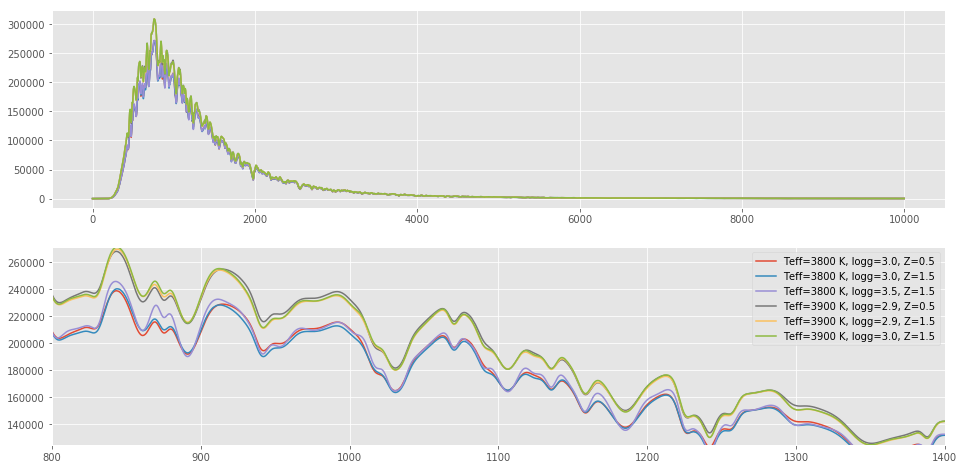

In [51]:
# set up some wavelengths
x = np.arange(0.1, 10000, 0.1)*u.nm
# set up some test parameters
teffs = np.array([3800, 3800, 3800, 3900, 3900, 3900])
loggs = np.array([3.0, 3.0, 3.5, 2.9, 2.9, 3.0])
zs = np.array([0.5, 1.5, 1.5, 0.5, 1.5, 1.5])
# plot
import matplotlib.pyplot as plt
%matplotlib inline
# set matplotlib style
plt.style.use('ggplot')

fig, frames = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(16, 8)

# loop around parameters:
for it in range(len(teffs)):
    # set up the label
    label = 'Teff={0} K, logg={1}, Z={2}'.format(teffs[it], loggs[it], zs[it])
    # get the model data for this iteration
    ymodel = model(teffs[it] * u.K, loggs[it], zs[it], x=x)
    # plot
    frames[0].plot(x, ymodel, label=label)
    frames[1].plot(x, ymodel, label=label)

# zoom in
xmask = (x > 800*u.nm) & (x < 1400*u.nm)
ymax, ymin = np.max(ymodel[xmask]), np.min(ymodel[xmask])
frames[1].set(xlim=(800, 1400), ylim=(ymin, ymax))
# legend
plt.legend(loc=0)


Now lets make a set of models (using itertools.product)

In [9]:
# imports
import itertools

# define parameters
teffs = np.arange(3000, 6250, 250.0) * u.K
loggs = np.arange(2, 6.5, 0.5)
zs = np.arange(-1.5, 2.0, 0.5)

# get all combinations of parameters
# get all combinations as a 1D list
combinations = list(itertools.product(teffs, loggs, zs))
# get the indices for combinations
indices = list(itertools.product(range(len(teffs)), range(len(loggs)), range(len(zs))))

# print number of combinations
print("Number of models required: {0}".format(len(combinations)))

Number of models required: 819


And generate the models:

In [10]:
# set up some wavelengths
x = np.arange(1.0, 10000, 5.0)*u.nm

# create 4D grid (Teff x logg x z x spectrum)
shape = [len(teffs), len(loggs), len(zs), len(x)]
grid = np.zeros(np.product(shape), dtype=float).reshape(shape)

# loop around parameters and add to 4D grid
for c in range(len(combinations)):
    # get this iteration
    index = indices[c]
    teff_c, logg_c, z_c = combinations[c]
    # load into grid
    grid[index[0], index[1], index[2]] = model(teff_c, logg_c, z_c, x=x)

/scratch/bin/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


Now add to regular grid interpolator.

interpolate.RegularGridInterpolator(parameters, grid)

where parameters is a list of lists of parameters i.e. [X, Y, Z] (where X = [1.1, 1.2, 1.3, 1.4] for example)

and grid has dimensions: [len(X), len(Y), len(Z), len(model)]

In [11]:
# imports
from scipy import interpolate

# interpolator
ipo = interpolate.RegularGridInterpolator([teffs, loggs, zs], grid)

Now we have access to the interpolation grid.

Lets test it:

In [12]:
# set up a label
label = 'Teff={0}   log(g)={1}   Z={2}'

# get the original values at a grid position
print('Grid position = [1, 1, 1]')
print('', label.format(teffs[1], loggs[1], zs[1]))

Grid position = [1, 1, 1]
 Teff=3250.0 K   log(g)=2.5   Z=-1.0


[Text(0,0.5,'Flux'), Text(0.5,0,'Wavelength [nm]')]

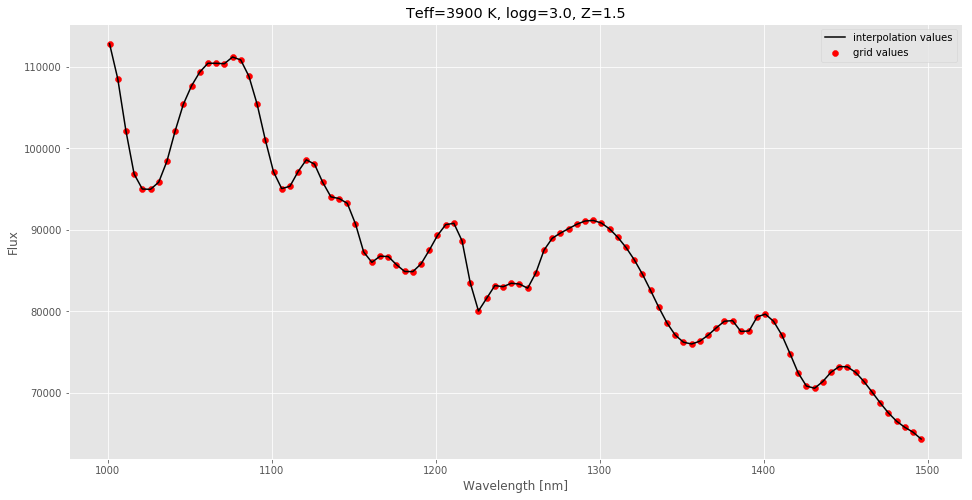

In [62]:
# set up some wavelengths
x = np.arange(1.0, 10000, 5.0)*u.nm
# get the interpolation at [1,1,1]
model111 = ipo([3250.0, 2.5, -1.0])[0]

# zoom in on region
zoommask = (x > 1000 * u.nm) & (x < 1500 * u.nm)
# set up figure
fig, frame = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(16, 8)
# plot the grid at [1,1,1]
frame.scatter(x[zoommask], grid[1, 1, 1][zoommask], color='r', label='grid values')
# plot the interpolatation
frame.plot(x[zoommask], model111[zoommask], color='k', label='interpolation values')
# title and labels
frame.legend()
frame.set_title(label.format(3250.0, 2.5, -1.0))
frame.set(xlabel='Wavelength [nm]', ylabel='Flux')


As you can see they match (not surpising given the interpolation grid is defined and fixed at the grid points)

Now we can interpolate at any value between the lower and upper bounds of the model parameters. 

Note that accessing and interpolation is very quick after the regular interpolation grid has been constructed (above).

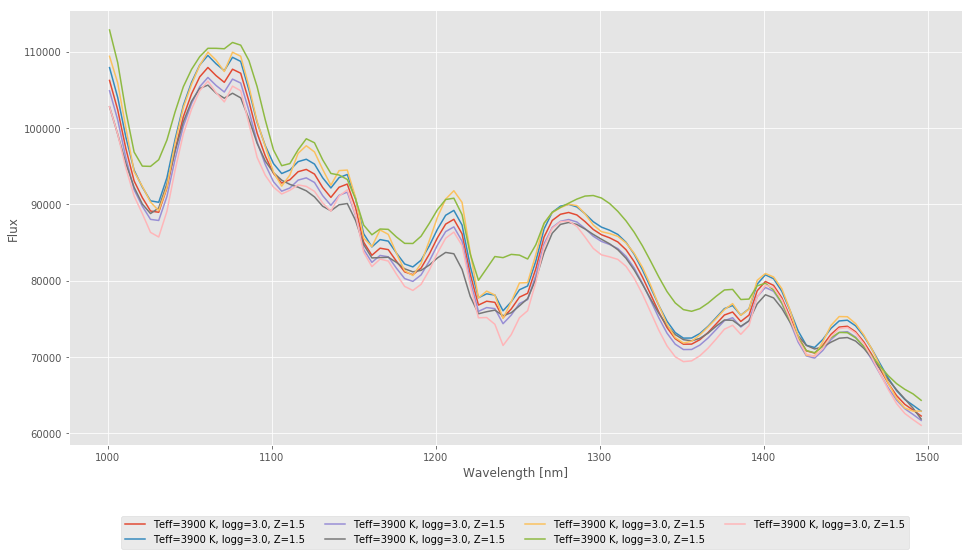

In [64]:
# set up intepolation cases (to loop around)
cases = [[3250.0, 2.5, 0.0],
         [3260.0, 2.5, 0.0], [3240.0, 2.5, 0.0],
         [3250.0, 2.0, 0.0], [3250.0, 3.0, 0.0],
         [3250.0, 2.5, -1.0], [3250.0, 2.5, 1.0]]
# zoom in on region
zoommask = (x > 1000 * u.nm) & (x < 1500 * u.nm)
# set up figure
fig, frame = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(16, 8)
# loop around cases
for case in cases:
    # get interpolation for this case
    model111 = ipo(case)[0]
    # plot the interpolatation
    frame.plot(x[zoommask], model111[zoommask], 
               label=label.format(*case))
# legend outside center left
plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=4)
_ = frame.set(xlabel='Wavelength [nm]', ylabel='Flux')



Note that as this interpolation is very quick it is very well suited for use in loops, chi-squared, MCMC anaylsis or other algorithms.

However it does require a regular grid of parameters and special care has to be taken with "holes" in parameter space where no model is present.